<span style="color: Gold"> Transformer

<span style="font-size:12px;">

# Self-Attention 정리

## 1. RNN의 한계
- RNN 계열은 **왼쪽 → 오른쪽** 순차 처리
- 멀리 떨어진 단어 간 영향 주고받기 어려움  
  예)  
  ```
  The cat that the boy who lived here adopted is sleeping
  ```
  → cat ↔ sleeping 거리 멀어서 연결 어려움

## 2. Self-Attention 기본 개념

### Q / K / V
- **Q(Query)** : 찾고 싶은 정보
- **K(Key)** : 가지고 있는 정보(비교 기준)
- **V(Value)** : 최종 전달할 정보

## 3. 단어 간 유사도 계산 예시

문장:
```
the cat sat on the mat
```

| 비교 대상 | 유사도 | 의미 |
|-----------|--------|------|
| cat vs the | 낮음 | the는 의미 없음 |
| cat vs cat | 높음 | 자기 자신 |
| cat vs sat | 중간 | 동사와 연결 |
| cat vs on | 낮음 | 전치사 |
| cat vs mat | 낮음 | 의미적으로 멀다 |

## 4. Softmax로 가중치 변환

유사도 → 확률처럼 변환

| 단어 | 가중치 |
|------|--------|
| the | 0.05 |
| cat | 0.6 |
| sat | 0.3 |
| mat | 0.05 |

출력:
```
0.1*value(the) + 0.7*value(cat) + 0.2*value(sat)
```

## 5. RNN vs Self-Attention
- RNN: **순차 처리**
- Self-Attention: **병렬 처리**

## 6. 다중 의미 처리 가능 예시
- **river bank** → river를 강하게 참조
- **bank loan** → loan을 강하게 참조  
→ 같은 bank라도 문맥 따라 다른 의미로 해석 </span>

---

<span style="color: Gold"> attention 시각화

Text(0, 0.5, 'quary')

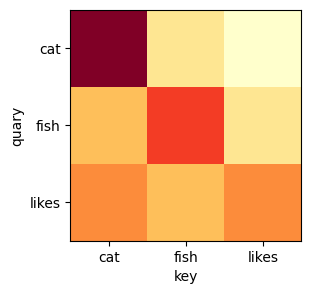

In [1]:
# self-attention 시각화
import numpy as np
import matplotlib.pyplot as plt


words = ['cat','fish','likes'] # 고양이가 생선을 좋아한다
# 가상의 attention 가중치
# 각 행은 해당 단어가 다른 단어들에게 주목하는 정도
attention_weight = np.array([
    [0.7,0.2,0.1], # cat은 자기자신에게 가장 높은 가중치
    [0.3,0.5,0.2],
    [0.4,0.3,0.4]])
flg, ax = plt.subplots(figsize =(8,3))
im = ax.imshow(attention_weight, cmap='YlOrRd')
ax.set_xticks(range(len(words)))
ax.set_yticks(range(len(words)))
ax.set_xticklabels(words)
ax.set_yticklabels(words)

ax.set_xlabel('key')
ax.set_ylabel('quary')
  

---

<span style="color: Gold"> Beam search (알고리즘)
- 문장을 생성할 때 다음에 나올 단어는 매우 많음 이걸 경우의 수로 따지면..?
- 상위 N개의 후보만 유지. N을 beam size라고 한다
- beam size = 1 -> 매번 가장 좋은 것만 선택 (Greedy)
- beam size = 4 4개의 가능성을 동시에 탐색

- Beam 사이즈
    - Beam = 1 (Greedy) 실시간 시스템
    - Beam = 4~5 품질과 속도의 균형(가장 일반적)
    - Beam = 8~10 최고품질이 필요한 경우는(논문, 공식문서)
    - Beam 이 크다고 좋지 않다 ... why 과도한 탐색 일반화 성능이 떨어진다 => 과적합

In [2]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
import time
MODEL_NAME = 't5-small'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

text = """summarize: The Amazon rainforest is the world's largest tropical rainforest.
  It covers much of northwestern Brazil and extends into Colombia, Peru and other South American countries.
  The Amazon is home to millions of species of plants and animals, many of which are found nowhere else on Earth.
  However, deforestation poses a significant threat to this vital ecosystem."""

print('원본 : ')
print(text.replace('summarize:',''))
inputs = tokenizer(text, return_tensors='pt',max_length=512,truncation=True).to(device)
# 다양한 beam size 실험
beam_sizes = [1,2,4,8]
results = []
for num_beams in beam_sizes:
  print(f' beam size : {num_beams}')
  start_time = time.time()
  outputs = model.generate(
      **inputs,
      num_beams = num_beams,
      max_length =60,
      min_length =20,
      early_stopping = True,
      no_repeat_ngram_size = 3,
      num_return_sequences = 1
  )
  elapsed_time = time.time() - start_time
  summary = tokenizer.decode(outputs[0],skip_special_tokens=True)
  results.append((num_beams, summary,elapsed_time))

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


원본 : 
 The Amazon rainforest is the world's largest tropical rainforest.
  It covers much of northwestern Brazil and extends into Colombia, Peru and other South American countries.
  The Amazon is home to millions of species of plants and animals, many of which are found nowhere else on Earth.
  However, deforestation poses a significant threat to this vital ecosystem.
 beam size : 1
 beam size : 2
 beam size : 4
 beam size : 8


<span style="color: lightblue;"> beam_sizes = [1,2,4,8]  
- 가장 높은 후보 1개를 볼때, 2개를 볼때, 4개를 볼때, 8개를 볼때에 따라 달라지는 결과를 확인하겠다는 의미

In [3]:
for num_beams, summary, elapsed_time in results:
  print(f'측정시간 : {elapsed_time}')
  print(f'beam size : {num_beams}')
  print(summary)


측정시간 : 1.651712417602539
beam size : 1
the amazon rainforest covers much of northwestern Brazil. it extends into Colombia, Peru and other South american countries.
측정시간 : 1.6909990310668945
beam size : 2
the amazon rainforest covers much of northwestern Brazil. it extends into Colombia, Peru and other south american countries.
측정시간 : 2.9629151821136475
beam size : 4
the amazon rainforest covers much of northwestern Brazil and extends into Colombia, Peru and other South American countries. deforestation poses a significant threat to this vital ecosystem.
측정시간 : 3.6378657817840576
beam size : 8
the amazon rainforest covers much of northwestern Brazil. it extends into Colombia, Peru and other south american countries.


<span style="color: Gold"> ROUGE 매트릭 </SPAN> : 텍스트 생성 모델의 품질을 측정하는 지표
- 모델이 생성한 문장과 정답 문장 간의 겹침 정도를 측정
- ROUGE의 주요 지표
   -  ROUGE-1	단어 단위 (Unigram)	겹치는 개별 단어의 수를 측정하여 단어 수준의 유사도를 평가
        - 예시
            - 정답 : 고양이가 생선을 먹었다
            - 생성 : 고양이가 물고기를 먹었다
            - 겹침 : 고양이가, 을, 먹었다    2/4 = 0.5
   - ROUGE-2	2개 단어 단위 (Bigram)	겹치는 연속된 2개의 단어 묶음의 수를 측정하며, 순서도 고려
    - ROUGE-L	최장 공통 부분 수열 (LCS)	단어의 순서는 유지되지만 연속적이지 않아도 겹침으로 인정. 문장 구조 및 내용의 흐름을 평가
- 단점 : 의지는 같지만 다른표현을 쓰면 점수가 낮다
    자동차 VS 차량 --> 겹침 없음으로 판단


토크나이저

<span style="color: Gold"> 배치처리, 데이터 콜레이터

In [4]:
from transformers import AutoTokenizer,DataCollatorForSeq2Seq, AutoModelForSeq2SeqLM
import torch
import time
# AutoModelForSeq2SeqLM(모델): 입력을 받아서 다른 텍스트를 생성하는 seq2seq 모델을 자동로드
# -> 인코더, 디코더 모델을 자동으로 
# -> T5, Bart, MarianMT
# -> 변역/요약/QA/ 문장변환에 특화   입력 -> 출력

# DataCollatorForSeq2Seq(도구) : seq2seq 학습시 배치단위로 패딩-정렬-라벨 시프트 등을 자동처리하는 데이터 정렬 도구
# 배치생성 - 길이가 다른 문장들을 동일길이로 패딩
# 라벨 시프트 - 라벨을 디코더 입력으로 사용   (teacher forcing 에 필요한 작업)
# DataLoader 안에서 사용

MODEL_NAME = 't5-small'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
model.eval()

texts = [
    "summarize: The cat sat on the mat.",
    "summarize: Python is a popular programming language.",
    "summarize: Machine learning is a subset of artificial intelligence.",
    "summarize: The weather is nice today.",
    "summarize: I love reading books in my free time.",
    "summarize: Coffee is one of the most popular beverages worldwide.",
    "summarize: Regular exercise is important for health.",
    "summarize: The Internet has changed how we communicate.",
]

# 개별처리 vs 배치처리
start_time = time.time()
result_indivisual = []
with torch.no_grad():
    for text in texts :
        inputs = tokenizer(text, return_tensors = 'pt', max_length=512, truncation = True).to(device)
        outputs = model.generate(**inputs,max_length= 30)
        summary = tokenizer.decode(outputs[0],skip_speclial_tokens = True)
        result_indivisual.append(summary)
    time_indivisual = time.time() - start_time
    print(f'소요시간 : {time_indivisual}')
    print(f'문장당 : {time_indivisual/len(texts):.4f}')


소요시간 : 3.5997655391693115
문장당 : 0.4500


In [5]:

# 배치처리
start_time = time.time()
result_batch = []
inputs = tokenizer(texts, return_tensors = 'pt', padding=True)
outputs = model.generate(**inputs,max_length=30)
for output in outputs:
  summary = tokenizer.decode(output, skip_special_tokens=True)
  result_batch.append(summary)
time_indivisual = time.time() - start_time
print(f'소요시간 : {time_indivisual}')
print(f'문장당: {time_indivisual / len(texts):.4f}')
     

소요시간 : 0.9133667945861816
문장당: 0.1142


In [6]:
# 데이터콜레이터
start_time = time.time()
data_collator =  DataCollatorForSeq2Seq(tokenizer=tokenizer,model=model, padding=True)
tokenized = []
for text in texts:
  encoded = tokenizer(text,truncation=True)
  tokenized.append(encoded)
batch = data_collator(tokenized)

time_indivisual = time.time() - start_time
print(f'소요시간 : {time_indivisual}')
print(f'문장당: {time_indivisual / len(texts):.4f}')

소요시간 : 0.006966352462768555
문장당: 0.0009


In [7]:
%pip install transformers torch datasets evaluate rouge-score sentencepiece accelerate pandas matplotlib


  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=25027 sha256=bb37b4af4111138ab4b7aa9435f8d9ed83d7e3d9ad757e7d75f4d94e0427348a
  Stored in directory: c:\users\samsung\appdata\local\pip\cache\wheels\5f\dd\89\461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
